# Data Loader

Read protocols from [here](https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts/files/?project=hasadna-oknesset&pli=1) (note that Google account is required) according to the metafile [kns_documentcommitteesession.csv](https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts?project=hasadna-oknesset&pli=1), and turn them into a table with the columns: committee's ID, section header (usually just the name of the speaker), and body. Note that each protocol corresponds to multiple rows - one row per section.

Explanatory Data Analysis (EDA) is also displayed for both metadata and data.

In [1]:
# Example for a table of data:
# 
# ID    Header     Body
# 1     Alice      hello
# 1     Bob        hey
# .....
# 2     Darth      this is you destiny!
# 2     Vader      I am your father.
# .....
# .....

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi

from Parser import show_freqs

In [4]:
mpl.rcParams.update({'font.size': 13})

In [5]:
# Configuration

DATA = Path('Data')

# from https://console.cloud.google.com/storage/browser/knesset-data-pipelines/data/committees/meeting_protocols_parts/?project=hasadna-oknesset&pli=1
META_SOURCE = DATA/'data_committees_meeting_protocols_parts_kns_documentcommitteesession.csv'

# credentials missing => url returns login page rather than csv; HTTPBasicAuth('user','pass') didn't work either.
# BASE_URL = r'https://storage.cloud.google.com/knesset-data-pipelines/data/committees/meeting_protocols_parts/'
# Using local path instead.
BASE_URL = 'Data/meeting_protocols_parts/'

save_data = False
path_meta = DATA/'meta.csv'
path_data = DATA/'data.csv'

# Get metadata

In [6]:
meta = pd.read_csv(META_SOURCE)
meta.rename(columns={'DocumentCommitteeSessionID':'ID'}, inplace=True)

### Metadata: EDA + clean errors

In [7]:
meta.head()

,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,protocol_extension,parsed_filename,filesize,crc32c,error
0,71333,65782,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/5/65782.csv,82050,LLmkqg==,NaN
1,71335,66045,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/6/66045.csv,99662,wwtRjQ==,NaN
2,71336,66046,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66046.csv,7113,ti5ZGA==,NaN
3,71337,66050,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66050.csv,35967,Wyoukw==,NaN
4,71340,66166,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66166.csv,57224,K+cm8w==,NaN


In [8]:
meta.tail()

,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,protocol_extension,parsed_filename,filesize,crc32c,error
40131,437950,2070060,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:20,20,NaN,NaN,0,NaN,parse_protocol returned None
40132,437951,2070643,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:30,20,NaN,NaN,0,NaN,parse_protocol returned None
40133,437952,2070736,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:42,20,NaN,NaN,0,NaN,parse_protocol returned None
40134,437953,2070380,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 10:30:52,20,NaN,NaN,0,NaN,parse_protocol returned None
40135,438053,2066333,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//20/Committees/20_ptv...,2018-07-02 18:00:32,20,NaN,NaN,0,NaN,parse_protocol returned None


In [9]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40136 entries, 0 to 40135
Data columns (total 14 columns):
ID                    40136 non-null int64
CommitteeSessionID    40136 non-null int64
GroupTypeID           40136 non-null int64
GroupTypeDesc         40136 non-null object
ApplicationID         40136 non-null int64
ApplicationDesc       40136 non-null object
FilePath              40136 non-null object
LastUpdatedDate       40136 non-null object
KnessetNum            40136 non-null int64
protocol_extension    37177 non-null object
parsed_filename       37177 non-null object
filesize              40136 non-null int64
crc32c                37177 non-null object
error                 2959 non-null object
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


Remove rows with errors (which in particular don't refer to any protocol):

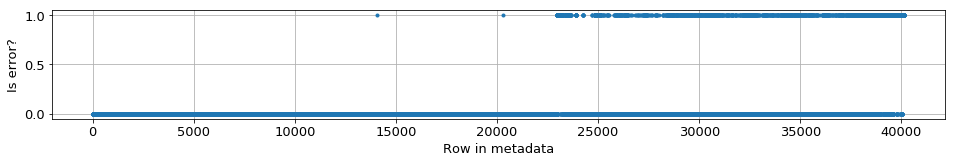

In [10]:
plt.figure(figsize=(16,2))
plt.plot([type(e) is str for e in meta.error], '.')
plt.xlabel('Row in metadata')
plt.ylabel('Is error?')
plt.grid()

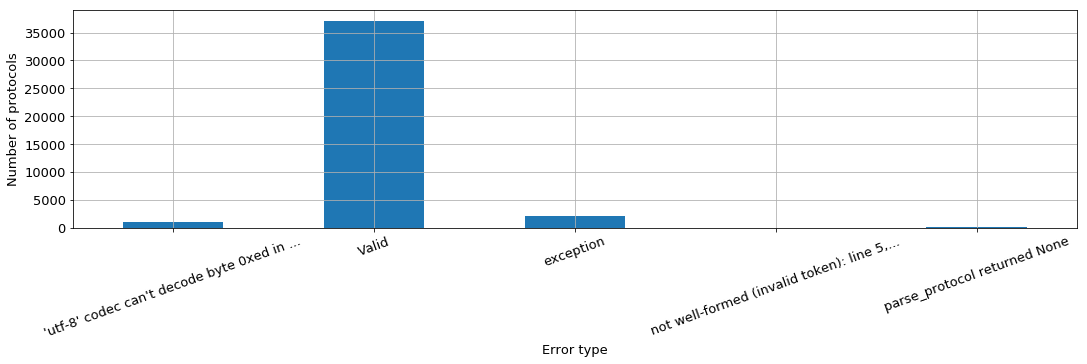

In [11]:
plt.figure(figsize=(18,4))
meta.ID.groupby([(e[:40]+('...' if len(e)>40 else '')) if type(e) is str else 'Valid'
                 for e in meta.error]).count().plot(kind='bar')
plt.xlabel('Error type')
plt.ylabel('Number of protocols')
plt.xticks(rotation=20)
plt.grid()

In [12]:
meta = meta.loc[[type(e) is not str for e in meta.error],:]
meta['i'] = list(range(len(meta)))

In [13]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37177 entries, 0 to 40052
Data columns (total 15 columns):
ID                    37177 non-null int64
CommitteeSessionID    37177 non-null int64
GroupTypeID           37177 non-null int64
GroupTypeDesc         37177 non-null object
ApplicationID         37177 non-null int64
ApplicationDesc       37177 non-null object
FilePath              37177 non-null object
LastUpdatedDate       37177 non-null object
KnessetNum            37177 non-null int64
protocol_extension    37177 non-null object
parsed_filename       37177 non-null object
filesize              37177 non-null int64
crc32c                37177 non-null object
error                 0 non-null object
i                     37177 non-null int64
dtypes: int64(7), object(8)
memory usage: 4.5+ MB


In [14]:
meta.describe()

,ID,CommitteeSessionID,GroupTypeID,ApplicationID,KnessetNum,filesize,i
count,37177.000000,3.717700e+04,37177.0,37177.0,37177.000000,37177.000000,37177.000000
mean,281717.538505,1.104325e+06,23.0,1.0,16.507572,73527.151492,18588.000000
std,119389.578654,8.407770e+05,0.0,0.0,2.954064,56451.118322,10732.219815
min,71333.000000,6.452900e+04,23.0,1.0,11.000000,42.000000,0.000000
25%,141532.000000,3.344270e+05,23.0,1.0,14.000000,33551.000000,9294.000000
50%,293216.000000,5.627160e+05,23.0,1.0,17.000000,67885.000000,18588.000000
75%,412682.000000,2.048592e+06,23.0,1.0,19.000000,101802.000000,27882.000000
max,437672.000000,2.068950e+06,23.0,1.0,20.000000,823828.000000,37176.000000


Committee ID is a serial with no gaps in 82% of rows.
Constant cols:	['GroupTypeID', 'GroupTypeDesc', 'ApplicationID', 'ApplicationDesc', 'protocol_extension', 'error']


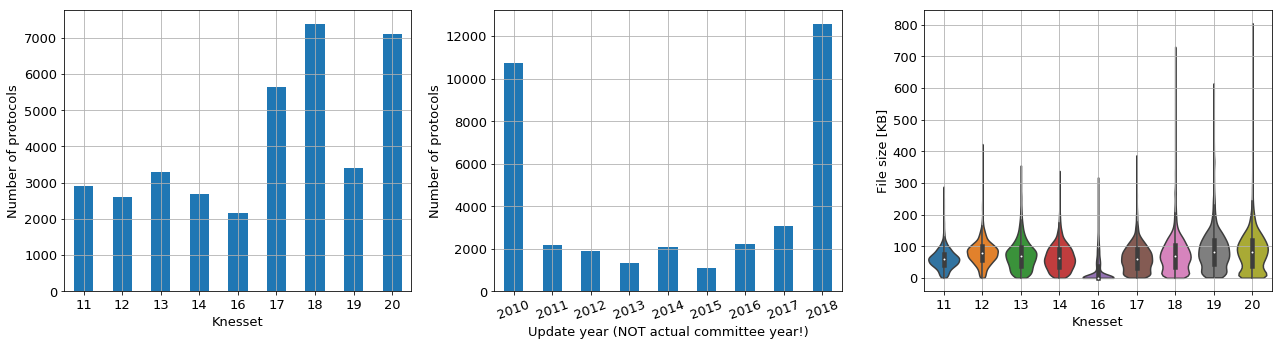

In [15]:
_, axs = plt.subplots(1,3, figsize=(18,5))

ax = axs[0]
meta.ID.groupby(meta.KnessetNum).count().plot(kind='bar', ax=ax)
ax.set_xlabel('Knesset')
ax.set_ylabel('Number of protocols')
ax.tick_params(axis='x', rotation=0)
ax.grid()

ax = axs[1]
meta.ID.groupby([s[:4] for s in meta.LastUpdatedDate]).count().plot(kind='bar', ax=ax)
ax.set_xlabel('Update year (NOT actual committee year!)')
ax.set_ylabel('Number of protocols')
ax.tick_params(axis='x', rotation=20)
ax.grid()

ax = axs[2]
sns.violinplot(x=meta.KnessetNum, y=meta.filesize/1024, scale='width', cut=0)
ax.set_xlabel('Knesset')
ax.set_ylabel('File size [KB]')
ax.tick_params(axis='x', rotation=0)
ax.grid()

plt.tight_layout()

print(f'Committee ID is a serial with no gaps in {100 * Counter(np.diff(meta.iloc[:,0]))[1] / len(meta):.0f}% of rows.')
print(f'Constant cols:\t',end='')
print([c for c in meta.columns if len(meta[c].unique())==1])

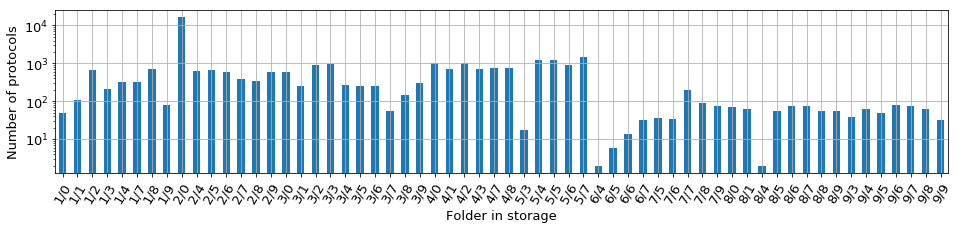

In [16]:
plt.figure(figsize=(16,3))
meta.ID.groupby([f[6:9] for f in meta.parsed_filename]).count().plot(kind='bar')
plt.xlabel('Folder in storage')
plt.ylabel('Number of protocols')
plt.xticks(rotation=60)
plt.yscale('log')
plt.grid()

# Get data

Reading the csv from the url requires google account credentials, which I didn't manage to gain programmatically.

Instead, the protocols files were downloaded and then locally loaded.

In [17]:
# To allow pandas allocate memory only once (much faster), we go over the files twice:
# once only to read the size (number of rows), then we allocate the whole data frame, and then a second time to read contents.

if save_data:
    
    tot_size = 0
    for f in tqdm_notebook(meta['parsed_filename']):
        if type(f) is str and f != '' and os.path.isfile(BASE_URL+f):
            tot_size += len(pd.read_csv(BASE_URL+f))
    print(f'Total number of rows:\t{tot_size:d}')

    df = pd.DataFrame(index=np.arange(tot_size), columns=('header','body','ID'))

    i = 0
    for sid,f in tqdm_notebook(zip(meta['ID'],meta['parsed_filename'])):
        if type(f) is str and f != '' and os.path.isfile(BASE_URL+f):
            tmp = pd.read_csv(BASE_URL+f)
            tmp.loc[:,'ID'] = sid
            df[i:i+len(tmp)] = tmp.values
            i += len(tmp)

    df.fillna('', inplace=True)
    
else:
    
    %time df = pd.read_csv(path_data)
    tot_size = len(df)
    df.fillna('', inplace=True)

Wall time: 36 s


In [18]:
print(f'Number of loaded protocols:\t{len(np.unique(df.ID)):d}/{len(meta):d} ({100*len(np.unique(df.ID))/len(meta):.1f}%)')
print('Data shape:\t', df.shape)

Number of loaded protocols:	37177/37177 (100.0%)
Data shape:	 (6760339, 4)


In [19]:
# remove rows in meta that could not be loaded
meta = meta[meta.ID.isin(df.ID)]
meta.shape

(37177, 15)

In [20]:
# temporal patch: get from local files
# RAW_PROTOCOLS = DATA/'Protocols'
# mask = r'data_committees_meeting_protocols_parts_files_'

# df = pd.DataFrame(columns=('ID','header','body'))
# for f in tqdm_notebook(os.listdir(RAW_PROTOCOLS)):
#     if f.startswith(mask):
#         i = np.where(meta.parsed_filename==f[len(mask)-6:].replace('_','/'))[0]
#         if len(i)<1:
#             warn(f'File missing in metadata:\t{f:s}.')
#             continue
#         elif len(i)>1:
#             warn(f'File {f:s} matches {len(i):d} entries in metadata.')
#         i = i[0]
#         tmp = pd.read_csv(RAW_PROTOCOLS/f)
#         tmp.loc[:,'ID'] = meta.loc[i,'ID']
#         df = pd.concat((df,tmp))
        
# df.fillna('', inplace=True)
 
# print(f'Number of loaded protocols:\t{len(np.unique(df.ID)):d}/{len(meta):d} ({100*len(np.unique(df.ID))/len(meta):.1f}%)')
# print(df.shape)

In [21]:
df.head()

,Unnamed: 0,header,body,ID
0,0,,p_tamars\r\n\r\n2006-01-11Liraz\r\n\r\n\r\n\r\...,71333.0
1,1,סדר היום,א. קביעת מסגרת דיון להצעות להביע אי-אמון בממשל...,71333.0
2,2,"היו""ר רוני בר-און",בוקר טוב. אני מתכבד לפתוח את ישיבה מס' 74 של ו...,71333.0
3,3,זהבה גלאון,"אני מציעה ללכת על ההסדר הקבוע לדיון משולב, כמו...",71333.0
4,4,"היו""ר רוני בר-און","מה שנהגנו לעשות עד כה - המציעים, אחר-כך 20 דקו...",71333.0


In [22]:
df.tail()

,Unnamed: 0,header,body,ID
6760334,6760334,יפעת רווה,מאיזה גילאים הם מגיעים? מה הצעירים ביותר?,437672.0
6760335,6760335,פאולה רושקה,של תחלואה כפולה?,437672.0
6760336,6760336,יפעת רווה,"באשפוז, אבל – שהיו אמורים להיות ב - - -",437672.0
6760337,6760337,פאולה רושקה,"מגיל 12, עקרונית, יכולים להגיע. היום השימוש הו...",437672.0
6760338,6760338,"היו""ר תמר זנדברג","אוקי, תודה פאולה, תודה לכולם, סליחה על הישיבה ...",437672.0


In [23]:
# Add protocol dates (assuming they appear as YYYY-mm-dd in the first section of the committee).
# Doesn't seem to work too well.

meta['date'] = None
l0 = len(meta)
for ID in tqdm_notebook(np.unique(df.ID)):
    i = np.where(meta.ID==ID)[0][0]
    try:
        date = re.findall('20[0-1][0-9]-[0-1][0-9]-[0-3][0-9]', df.loc[df.ID==ID,'body'].values[0])[0]
    except:
        if False:
            print(f'Couldn\'t parse date for protocol #{int(ID):d}.')
        continue
    date = datetime.strptime(date, '%Y-%m-%d').date()
    meta.iloc[i, meta.columns.get_loc('date')] = date
    assert len(meta)==l0

A Jupyter Widget

In [24]:
print(f'Parsed dates:\t{np.logical_not(meta.date.isnull()).sum():.0f} ({100*np.logical_not(meta.date.isnull()).mean():.1f}%)')
meta[np.logical_not(meta.date.isnull())].head()

Parsed dates:	26794 (72.1%)


,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,protocol_extension,parsed_filename,filesize,crc32c,error,i,date
0,71333,65782,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/5/65782.csv,82050,LLmkqg==,NaN,0,2006-01-11
1,71335,66045,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,.doc,files/6/6/66045.csv,99662,wwtRjQ==,NaN,1,2006-01-11
2,71336,66046,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66046.csv,7113,ti5ZGA==,NaN,2,2006-01-11
3,71337,66050,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66050.csv,35967,Wyoukw==,NaN,3,2006-01-11
4,71340,66166,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,.doc,files/6/6/66166.csv,57224,K+cm8w==,NaN,4,2006-01-11


In [25]:
meta.shape

(37177, 16)

In [26]:
if save_data:
    meta.to_csv(path_meta, encoding='utf-8')
    df.to_csv(path_data, encoding='utf-8')

### EDA

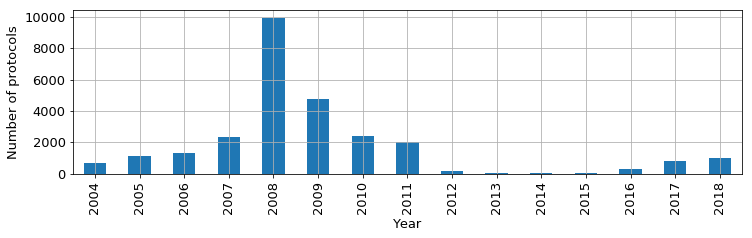

In [27]:
plt.figure(figsize=(12,3))
meta.ID.groupby([d.year if d else None for d in meta.date]).count().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of protocols')
plt.grid()

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


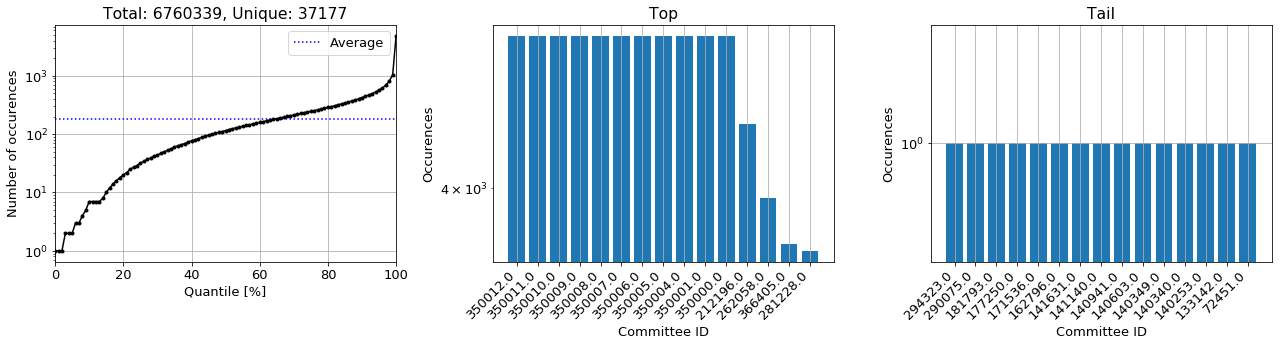

In [28]:
# show longest committees
null = show_freqs(np.array(df.ID,dtype=str), token_lab='Committee ID', compact=True)

In [29]:
# print suspiciously short protocol
print(df.loc[df.ID==131344])
print(df.loc[df.ID==131344].body.values[0])
print(df.loc[df.ID==131344].body.values[-1])

       Unnamed: 0        header  \
38933       38933                 
38934       38934         נכחו:   
38935       38935   חברי הוועדה   
38936       38936    חברי הכנסת   
38937       38937       מוזמנים   
38938       38938  יועצת משפטית   
38939       38939  מנהלת הוועדה   

                                                    body        ID  
38933  knesset\r\n\r\n2004-11-15Liraz\r\n\r\n\r\n\r\n...  131344.0  
38934                                                     131344.0  
38935                                                     131344.0  
38936                                                     131344.0  
38937                                                     131344.0  
38938                                                     131344.0  
38939  סדר היום : פריט ועדה צווים, צו פעוטות בסיכון (...  131344.0  
knesset

2004-11-15Liraz



הכנסת 16

מושב 1

פרוטוקול מס' 250

מישיבת ועדת העבודה, הרווחה והבריאות

יום שני, כ"ו תשרי, תשס"ה, 11/10/04, שעה 11:00
סדר היום : פריט ועדה

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


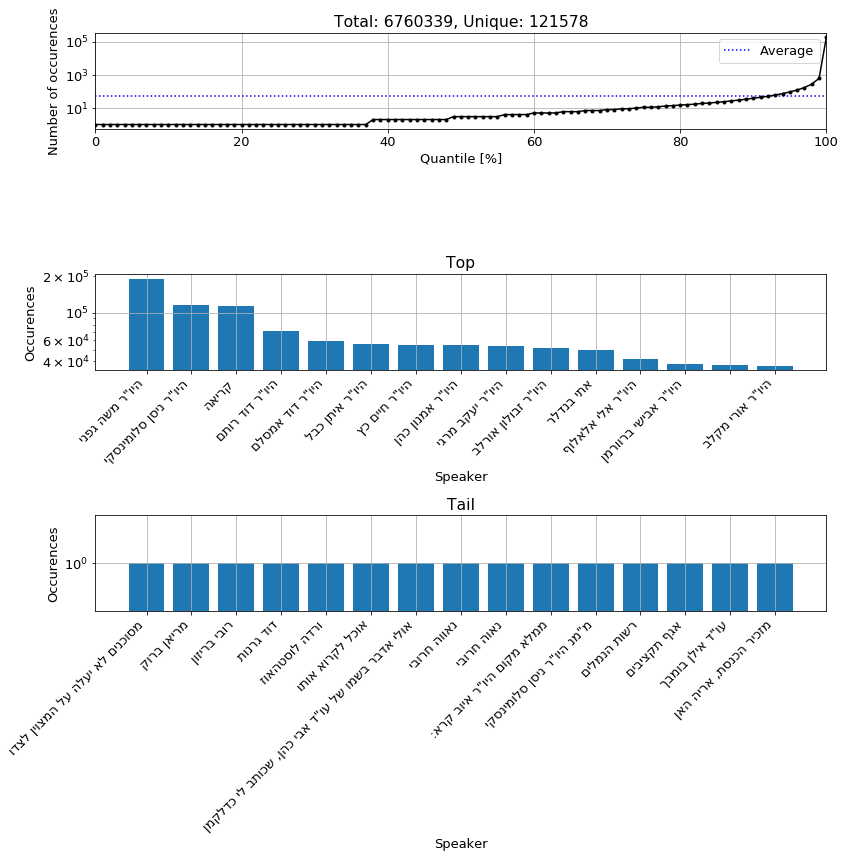

In [30]:
# show top speakers
speakers, freqs = show_freqs(df.header, token_lab='Speaker')

In [31]:
print(speakers[:200])

['היו"ר משה גפני', 'היו"ר ניסן סלומינסקי', 'קריאה', 'היו"ר דוד רותם', 'היו"ר דוד אמסלם', 'היו"ר איתן כבל', 'היו"ר חיים כץ', 'היו"ר אמנון כהן', 'היו"ר יעקב מרגי', 'היו"ר זבולון אורלב', 'אתי בנדלר', 'היו"ר אלי אלאלוף', 'היו"ר אבישי ברוורמן', '', 'היו"ר אורי מקלב', 'היו"ר מירי רגב', 'משה גפני', 'היו"ר קארין אלהרר', 'היו"ר מנחם בן-ששון', 'היו"ר יואב קיש', 'שגית אפיק', 'נכחו', 'ראובן ריבלין', 'היו"ר מיכאל מלכיאור', 'היו"ר גלעד ארדן', 'קריאות', 'חיים אורון', 'היו"ר דוד אזולאי', 'תומר רוזנר', 'מירב ישראלי', 'היו"ר עמרם מצנע', 'היו"ר אופיר פינס-פז', 'דב חנין', 'שלי יחימוביץ', 'היו"ר כרמל שאמה-הכהן', 'מיקי רוזנטל (המחנה הציוני)', 'יעקב ליצמן', 'לאה ורון', 'היו"ר אופיר אקוניס', 'איתי עצמון', 'אורי מקלב', 'סדר היום', 'היו"ר כרמל שאמה', 'היו"ר עאידה תומא סלימאן', 'סיגל קוגוט', 'היו"ר דוד ביטן', 'היו"ר אלכס מילר', 'מיקי לוי (יש עתיד)', 'היו"ר יריב לוין', 'היו"ר ישראל אייכלר', 'זבולון אורלב', 'היו"ר סתיו שפיר', 'דוד ביטן (הליכוד)', 'אברהם מיכאלי', 'תמי סלע', 'דוד רותם', 'ארבל אסטרחן', 'נעה בן שבת', 